In [1]:
#A code to analyze image cubes from the JWST nirspec ifu
#By Sam Federman, Adam E. Rubinstein

# load important packages
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import os
import sys

from astropy.io import fits, ascii
from astropy import units as u
from astropy.visualization import ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch
import pandas as pd
from spectral_cube import SpectralCube

In [2]:
#a new fits file to be saved, maybe viewed in DS9
# may need to modify the function for a particular image, but generally useful
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution...
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name can be the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''
    
    #just setup an fits HDU from the data
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
        #saving the file
    #         name_fixfit = name[:-3] + 'fits'
#         new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
#         hdul.writeto(save_path+new_filename, overwrite=True)
    hdul.writeto(save_path+name, overwrite=True)     
    return (save_path+name)

In [4]:
#if needing to sum a line or cube beforehand..
composite_folder = 'Composite_Images/'
filelist = [composite_folder+'HOPS370_NIRspec_cube_H2_S11.fits', composite_folder+'HOPS370_NIRspec_cube_HI_4.05.fits']
save_list = [composite_folder+'HOPS370_H2_S11_sum.fits', composite_folder+'HOPS370_HI_4.05_sum.fits']

for file, save_path in zip(filelist, save_list):
    hdul = fits.open(file)
    jwst_cube = SpectralCube.read(hdul[0]) #accessing the cube for data  
    hdul.close()
    jwst_data = np.array(jwst_cube._data, dtype=np.float64)
    line_sum = np.sum(jwst_data, axis=0) #along wavelength axis, maintaining image

    #save
    saved = fits_saver(line_sum, jwst_cube.header, save_path, '')
    print(saved)

Composite_Images/HOPS370_H2_S11_sum.fits
Composite_Images/HOPS370_HI_4.05_sum.fits


In [4]:
#this cell is to show composites made from nested layers of different gas (jet + outflows + scattered light)

#loop and save all composites using aplpy
from aplpy import make_rgb_image

# Read in data and header
path = 'Composite_Images/' #where are your composites?
protostar_list = ['B335', 'HOPS153', 'HOPS370', 'IRAS16253', 'IRAS20126'] #all our protostars

#setting up color notes as a dictionary for convenience. 
#order is protostar:[(vmin, vmid)_r...()_b], assuming asinh scaling
#values can be estimated in DS9
# colors_dict = {protostar_list[0] : [('asinh', 'asinh', 'asinh'), (2e-19, 0.1), (1e-25, 0.2), (1e-22, 0.05)], \
#                protostar_list[1] : [('asinh', 'asinh', 'asinh'), (1e-19, 0.75), (1e-20, 0.8), (2.15817e-18, 0.1)], \
#                protostar_list[2] : [('asinh', 'asinh', 'asinh'), (0, 0.2), (0, 0.75), (0, 0.35)], \
#                protostar_list[3] : [('asinh', 'asinh', 'asinh'), (0, 0.4), (0, 0.1), (0, 0.03)], \
#                protostar_list[4] : [('asinh', 'asinh', 'asinh'), (0, 0.2), (0, 0.75), (0, 0.35)]
#                 }

#a related attempt using log sometimes
colors_dict = {protostar_list[0] : [('asinh', 'asinh', 'linear'), (0, 8e-3), (0, 1e-1), (0, 1e-19)], \
               protostar_list[1] : [('asinh', 'asinh', 'linear'), (0, 9e-2), (4.12998e-07, 5e-1), (0, 3e-19)], \
               protostar_list[2] : [('asinh', 'log', 'linear'), (-4.21237e-05, 5e-2), (0, 2e-2), (-1.07629e-17, 1.95165e-16)], \
               protostar_list[3] : [('asinh', 'asinh', 'linear'), (3.51101e-07, 5e-2), (5.90506e-07, 3e-2), (-2.62358e-20, 1.34876e-19)], \
               protostar_list[4] : [('sqrt', 'asinh', 'asinh'), (0, 1e-6), (0, 2e-2), (0, 3e-2)]
                }
#loop!
%matplotlib inline
import matplotlib.image as mpimg
ind = 3
protostar_sublist = [protostar_list[ind]] #have to run this 1 at a time...can't think of better way

#IMPORTANT: before running make sure the protostar you're doing has the right aplpy params
#(i.e. asinh uses vmid_r...vmid_b, while linear uses pmax_r...pmax_b)
for protostar in protostar_sublist:
    try:
        path_list = [i.replace('\\', '/') for i in glob(path+protostar+'*.fits')] #glob a set of images
        
        # print(path_list)
        # sys.exit()

        #check for what we want to plot, mostly just if you want to change between HI and [FeII]
        if ind == 0 or ind == 1 or ind == 3: #in other words, if lower mass
            path_sub_list = [path_list[3], path_list[5], path_list[0]]
            #if not just using asinh
            make_rgb_image(path_sub_list, output=path+protostar+'_NIRSpec_rgb_nestedLayers.eps', \
                    stretch_r=colors_dict[protostar][0][0], vmin_r=colors_dict[protostar][1][0], vmid_r=colors_dict[protostar][1][1], \
                    stretch_g=colors_dict[protostar][0][1], vmin_g=colors_dict[protostar][2][0], vmid_g=colors_dict[protostar][2][1], \
                    stretch_b=colors_dict[protostar][0][2], vmin_b=colors_dict[protostar][3][0], vmax_b=colors_dict[protostar][3][1], )
        elif ind == 2: #if higher mass
            path_sub_list = [path_list[2], path_list[6], path_list[0]]
            #if not just using asinh
            make_rgb_image(path_sub_list, output=path+protostar+'_NIRSpec_rgb_nestedLayers.eps', \
                    stretch_r=colors_dict[protostar][0][0], vmin_r=colors_dict[protostar][1][0], vmid_r=colors_dict[protostar][1][1], \
                    stretch_g=colors_dict[protostar][0][1], vmin_g=colors_dict[protostar][2][0], vmax_g=colors_dict[protostar][2][1], \
                    stretch_b=colors_dict[protostar][0][2], vmin_b=colors_dict[protostar][3][0], vmax_b=colors_dict[protostar][3][1], )
        elif ind == 4: #if higher mass
            path_sub_list = [path_list[2], path_list[5], path_list[0]]
            make_rgb_image(path_sub_list, output=path+protostar+'_NIRSpec_rgb_nestedLayers.eps', \
                stretch_r=colors_dict[protostar][0][0], vmin_r=colors_dict[protostar][1][0], vmid_r=colors_dict[protostar][1][1], \
                stretch_g=colors_dict[protostar][0][1], vmin_g=colors_dict[protostar][2][0], vmid_g=colors_dict[protostar][2][1], \
                stretch_b=colors_dict[protostar][0][2], vmin_b=colors_dict[protostar][3][0], vmid_b=colors_dict[protostar][3][1], )
        
        print(path_sub_list)

        #then plot,
        #if using asinh
        # make_rgb_image(path_sub_list, output=path+protostar+'_NIRSpec_rgb_nestedLayers.png', \
        #             stretch_r=colors_dict[protostar][0][0], vmin_r=colors_dict[protostar][1][0], vmid_r=colors_dict[protostar][1][1], \
        #             stretch_g=colors_dict[protostar][0][1], vmin_g=colors_dict[protostar][2][0], vmid_g=colors_dict[protostar][2][1], \
        #             stretch_b=colors_dict[protostar][0][2], vmin_b=colors_dict[protostar][3][0], vmid_b=colors_dict[protostar][3][1], )

    except ValueError as e:
        #display to check the results
        img = mpimg.imread(path+protostar+'_NIRSpec_rgb_nestedLayers.eps')
        imgplot = plt.imshow(img)
        plt.show()

INFO: Red: [aplpy.rgb]
INFO: vmin =  3.511e-07 [aplpy.rgb]
INFO: vmax =  3.348e-06 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin =  5.905e-07 [aplpy.rgb]
INFO: vmax =  2.921e-05 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -2.624e-20 [aplpy.rgb]
INFO: vmax =  1.349e-19 [aplpy.rgb]
['Composite_Images/IRAS16253_NIRspec_cube_basefit_tophat_jcbd_FeII_4.8891387.fits', 'Composite_Images/IRAS16253_NIRspec_cube_basefit_tophat_jcbd_H2 v=0 - 0 S 11_4.1810775.fits', 'Composite_Images/IRAS16253_NIRspec_Continuum_med.fits']


INFO: Red: [aplpy.rgb]
INFO: vmin =  0.000e+00 [aplpy.rgb]
INFO: vmax =  7.299e-04 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin =  0.000e+00 [aplpy.rgb]
INFO: vmax =  2.113e-03 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin =  0.000e+00 [aplpy.rgb]
INFO: vmax =  2.084e-04 (auto) [aplpy.rgb]


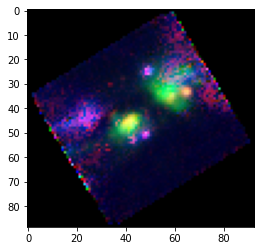

In [421]:
#this cell is to show composites made from the jet (FeII, CO, BrA)

# Read in data and header
path = 'Composite_Images/' #where are your composites?
protostar_list = ['B335', 'HOPS153', 'HOPS370', 'IRAS16253', 'IRAS20126'] #all our protostars

#setting up color notes as a dictionary for convenience. 
#order is protostar:[(vmin, vmid)_r...()_b], assuming asinh scaling
#values can be estimated in DS9
colors_dict = {protostar_list[0] : [('asinh', 'asinh', 'asinh'), (0, 0.1), (0, 0.2), (0, 0.02)], \
               protostar_list[1] : [('asinh', 'asinh', 'asinh'), (0, 0.3), (0, 0.3), (1e-6, 0.5)], \
               protostar_list[2] : [('asinh', 'asinh', 'asinh'), (0, 0.01), (0, 0.01), (0, 0.01)], \
               protostar_list[3] : [('asinh', 'sqrt', 'asinh'), (0, 0.4), (0, 0.05), (0, 0.05)], \
               protostar_list[4] : [('asinh', 'asinh', 'asinh'), (0, 0.1), (0, 0.1), (0, 0.1)]
                }

#a related attempt using log sometimes
# colors_dict = {protostar_list[0] : [('asinh', 'asinh', 'linear'), (0, 8e-3), (0, 1e-1), (0, 1e-19)], \
#                protostar_list[1] : [('asinh', 'asinh', 'linear'), (0, 9e-2), (4.12998e-07, 5e-1), (0, 3e-19)], \
#                protostar_list[2] : [('asinh', 'log', 'linear'), (-4.21237e-05, 5e-2), (0, 2e-2), (-1.07629e-17, 1.95165e-16)], \
#                protostar_list[3] : [('asinh', 'asinh', 'linear'), (3.51101e-07, 5e-2), (5.90506e-07, 3e-2), (-2.62358e-20, 1.34876e-19)], \
#                protostar_list[4] : [('sqrt', 'asinh', 'asinh'), (0, 1e-6), (0, 2e-2), (0, 3e-2)]
#                 }
#loop!
%matplotlib inline
import matplotlib.image as mpimg
ind = 4
protostar_sublist = [protostar_list[ind]] #have to run this 1 at a time...can't think of better way

#IMPORTANT: before running make sure the protostar you're doing has the right aplpy params
#(i.e. asinh uses vmid_r...vmid_b, while linear uses pmax_r...pmax_b)
for protostar in protostar_sublist:
    try:
        path_list = [i.replace('\\', '/') for i in glob(path+protostar+'*.fits')] #glob a set of images
        
        # print(path_list)
        # sys.exit()

        #check for what we want to plot, mostly just if you want to change between HI and [FeII]
        if ind == 0 or ind == 1 or ind == 3: #in other words, if lower mass
            path_sub_list = [path_list[3], path_list[1], path_list[-2]]
            #if not just using asinh
            make_rgb_image(path_sub_list, output=path+protostar+'_NIRSpec_rgb_jet.png', \
                    stretch_r=colors_dict[protostar][0][0], vmin_r=colors_dict[protostar][1][0], vmid_r=colors_dict[protostar][1][1], \
                    stretch_g=colors_dict[protostar][0][1], vmin_g=colors_dict[protostar][2][0], vmid_g=colors_dict[protostar][2][1], \
                    stretch_b=colors_dict[protostar][0][2], vmin_b=colors_dict[protostar][3][0], vmid_b=colors_dict[protostar][3][1], )
        elif ind == 2 or ind==4: #if higher mass
            path_sub_list = [path_list[2], path_list[1], path_list[-2]]
            #if not just using asinh
            make_rgb_image(path_sub_list, output=path+protostar+'_NIRSpec_rgb_jet.png', \
                    stretch_r=colors_dict[protostar][0][0], vmin_r=colors_dict[protostar][1][0], vmid_r=colors_dict[protostar][1][1], \
                    stretch_g=colors_dict[protostar][0][1], vmin_g=colors_dict[protostar][2][0], vmid_g=colors_dict[protostar][2][1], \
                    stretch_b=colors_dict[protostar][0][2], vmin_b=colors_dict[protostar][3][0], vmid_b=colors_dict[protostar][3][1], )
        
        print(path_sub_list)

    except ValueError as e:
        #display to check the results
        img = mpimg.imread(path+protostar+'_NIRSpec_rgb_jet.png')
        imgplot = plt.imshow(img)
        plt.show()


['Composite_Images/IRAS20126_NIRspec_Continuum_med.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_CO v=1 - 0 P 15_4.8030686.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_FeII_4.4348335.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_FeII_4.8891387.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_H2 v=0 - 0 S 10_4.409791.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_H2 v=0 - 0 S 11_4.1810775.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_H2 v=0 - 0 S 12_3.9961467.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_H2 v=0 - 0 S 8_5.053115.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_H2 v=0 - 0 S 9_4.694614.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_HI(BrA)_4.0522695.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_HI(PfB)_4.65378.fits']
['Composite_Images/IRAS20126_NIRspec_cube_basef

c:\Users\arubi\anaconda3\lib\site-packages\pyavm\avm.py:647: UserWarning: cannot represent WCS as a Scale and Rotation, using deprecated CDMatrix instead
  warnings.warn("cannot represent WCS as a Scale and Rotation, using deprecated CDMatrix instead")


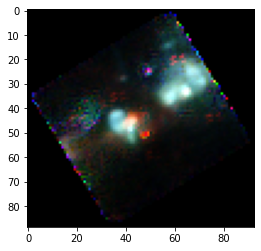

In [465]:
#this cell is to show composites made from the jet (FeII, CO, BrA)

# Read in data and header
path = 'Composite_Images/' #where are your composites?
protostar_list = ['B335', 'HOPS153', 'HOPS370', 'IRAS16253', 'IRAS20126'] #all our protostars

#setting up color notes as a dictionary for convenience. 
#order is protostar:[(vmin, vmid)_r...()_b], assuming asinh scaling
#values can be estimated in DS9
colors_dict = {protostar_list[0] : [('asinh', 'asinh', 'asinh'), (0, 0.1), (0, 0.1), (0, 0.1)], \
               protostar_list[1] : [('sqrt', 'asinh', 'asinh'), (0, 0.1), (0, 0.2), (0, 0.2)], \
               protostar_list[2] : [('log', 'log', 'log'), (0, 0.1), (0, 0.1), (0, 0.1)], \
               protostar_list[3] : [('asinh', 'asinh', 'asinh'), (0, 0.1), (0, 0.1), (0, 0.1)], \
               protostar_list[4] : [('asinh', 'asinh', 'asinh'), (0, 0.1), (0, 0.1), (0, 0.1)]
                }

#a related attempt using log sometimes
# colors_dict = {protostar_list[0] : [('asinh', 'asinh', 'linear'), (0, 8e-3), (0, 1e-1), (0, 1e-19)], \
#                protostar_list[1] : [('asinh', 'asinh', 'linear'), (0, 9e-2), (4.12998e-07, 5e-1), (0, 3e-19)], \
#                protostar_list[2] : [('asinh', 'log', 'linear'), (-4.21237e-05, 5e-2), (0, 2e-2), (-1.07629e-17, 1.95165e-16)], \
#                protostar_list[3] : [('asinh', 'asinh', 'linear'), (3.51101e-07, 5e-2), (5.90506e-07, 3e-2), (-2.62358e-20, 1.34876e-19)], \
#                protostar_list[4] : [('sqrt', 'asinh', 'asinh'), (0, 1e-6), (0, 2e-2), (0, 3e-2)]
#                 }
#loop!
%matplotlib inline
import matplotlib.image as mpimg
ind = 4
protostar_sublist = [protostar_list[ind]] #have to run this 1 at a time...can't think of better way

#IMPORTANT: before running make sure the protostar you're doing has the right aplpy params
#(i.e. asinh uses vmid_r...vmid_b, while linear uses pmax_r...pmax_b)
for protostar in protostar_sublist:
    try:
        path_list = [i.replace('\\', '/') for i in glob(path+protostar+'*.fits')] #glob a set of images

        print(path_list)
        
        # print(path_list)
        # sys.exit()

        #check for what we want to plot, mostly just if you want to change between HI and [FeII]
        if ind == 0 or ind == 1 or ind == 3 or ind == 4: #in other words, if lower mass
            path_sub_list = [path_list[7], path_list[4], path_list[6]]
            print(path_sub_list)    

            #if not just using asinh
            make_rgb_image(path_sub_list, output=path+protostar+'_NIRSpec_rgb_molecular.png', \
                    stretch_r=colors_dict[protostar][0][0], vmin_r=colors_dict[protostar][1][0], vmid_r=colors_dict[protostar][1][1], \
                    stretch_g=colors_dict[protostar][0][1], vmin_g=colors_dict[protostar][2][0], vmid_g=colors_dict[protostar][2][1], \
                    stretch_b=colors_dict[protostar][0][2], vmin_b=colors_dict[protostar][3][0], vmid_b=colors_dict[protostar][3][1], )

        
        elif ind == 2: #if higher mass
            path_sub_list = [path_list[8], path_list[5], path_list[7]]
            print(path_sub_list)
            
                       #if not just using asinh
            make_rgb_image(path_sub_list, output=path+protostar+'_NIRSpec_rgb_molecular.png', \
                    stretch_r=colors_dict[protostar][0][0], vmin_r=colors_dict[protostar][1][0], vmid_r=colors_dict[protostar][1][1], \
                    stretch_g=colors_dict[protostar][0][1], vmin_g=colors_dict[protostar][2][0], vmid_g=colors_dict[protostar][2][1], \
                    stretch_b=colors_dict[protostar][0][2], vmin_b=colors_dict[protostar][3][0], vmid_b=colors_dict[protostar][3][1], )
                


    except ValueError as e:
        #display to check the results
        img = mpimg.imread(path+protostar+'_NIRSpec_rgb_molecular.png')
        imgplot = plt.imshow(img)
        plt.show()


['Composite_Images/IRAS20126_NIRspec_Continuum_med.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_CO v=1 - 0 P 15_4.8030686.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_FeII_4.4348335.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_FeII_4.8891387.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_H2 v=0 - 0 S 10_4.409791.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_H2 v=0 - 0 S 11_4.1810775.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_H2 v=0 - 0 S 12_3.9961467.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_H2 v=0 - 0 S 8_5.053115.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_H2 v=0 - 0 S 9_4.694614.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_HI(BrA)_4.0522695.fits', 'Composite_Images/IRAS20126_NIRspec_cube_basefit_tophat_jcbd_HI(PfB)_4.65378.fits']
['Composite_Images/IRAS20126_NIRspec_cube_basef

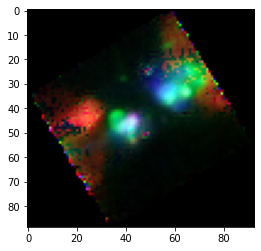

In [501]:
#this cell is to show composites made from the jet (FeII, CO, BrA)

# Read in data and header
path = 'Composite_Images/' #where are your composites?
protostar_list = ['B335', 'HOPS153', 'HOPS370', 'IRAS16253', 'IRAS20126'] #all our protostars

#setting up color notes as a dictionary for convenience. 
#order is protostar:[(vmin, vmid)_r...()_b], assuming asinh scaling
#values can be estimated in DS9
colors_dict = {protostar_list[0] : [('asinh', 'asinh', 'asinh'), (0, 0.1), (0, 0.2), (0, 0.1)], \
               protostar_list[1] : [('asinh', 'asinh', 'asinh'), (0, 0.2), (0, 0.5), (0, 0.05)], \
               protostar_list[2] : [('asinh', 'asinh', 'log'), (0, 0.01), (0, 0.1), (0, 0.1)], \
               protostar_list[3] : [('asinh', 'asinh', 'asinh'), (0, 0.1), (0, 0.1), (0, 0.05)], \
               protostar_list[4] : [('asinh', 'asinh', 'asinh'), (0, 0.1), (0, 0.1), (0, 0.1)]
                }

#a related attempt using log sometimes
# colors_dict = {protostar_list[0] : [('asinh', 'asinh', 'linear'), (0, 8e-3), (0, 1e-1), (0, 1e-19)], \
#                protostar_list[1] : [('asinh', 'asinh', 'linear'), (0, 9e-2), (4.12998e-07, 5e-1), (0, 3e-19)], \
#                protostar_list[2] : [('asinh', 'log', 'linear'), (-4.21237e-05, 5e-2), (0, 2e-2), (-1.07629e-17, 1.95165e-16)], \
#                protostar_list[3] : [('asinh', 'asinh', 'linear'), (3.51101e-07, 5e-2), (5.90506e-07, 3e-2), (-2.62358e-20, 1.34876e-19)], \
#                protostar_list[4] : [('sqrt', 'asinh', 'asinh'), (0, 1e-6), (0, 2e-2), (0, 3e-2)]
#                 }
#loop!
%matplotlib inline
import matplotlib.image as mpimg
ind = 4
protostar_sublist = [protostar_list[ind]] #have to run this 1 at a time...can't think of better way

#IMPORTANT: before running make sure the protostar you're doing has the right aplpy params
#(i.e. asinh uses vmid_r...vmid_b, while linear uses pmax_r...pmax_b)
for protostar in protostar_sublist:
    try:
        path_list = [i.replace('\\', '/') for i in glob(path+protostar+'*.fits')] #glob a set of images

        print(path_list)
        
        # print(path_list)
        # sys.exit()

        #check for what we want to plot, mostly just if you want to change between HI and [FeII]
        if ind == 0 or ind == 1 or ind == 3 or ind == 4: #in other words, if lower mass
            path_sub_list = [path_list[3], path_list[4], path_list[1]]
            print(path_sub_list)    

            #if not just using asinh
            make_rgb_image(path_sub_list, output=path+protostar+'_NIRSpec_rgb_mixing.png', \
                    stretch_r=colors_dict[protostar][0][0], vmin_r=colors_dict[protostar][1][0], vmid_r=colors_dict[protostar][1][1], \
                    stretch_g=colors_dict[protostar][0][1], vmin_g=colors_dict[protostar][2][0], vmid_g=colors_dict[protostar][2][1], \
                    stretch_b=colors_dict[protostar][0][2], vmin_b=colors_dict[protostar][3][0], vmid_b=colors_dict[protostar][3][1], )

        
        elif ind == 2: #if higher mass
            path_sub_list = [path_list[2], path_list[5], path_list[1]]
            print(path_sub_list)
            
                       #if not just using asinh
            make_rgb_image(path_sub_list, output=path+protostar+'_NIRSpec_rgb_mixing.png', \
                    stretch_r=colors_dict[protostar][0][0], vmin_r=colors_dict[protostar][1][0], vmid_r=colors_dict[protostar][1][1], \
                    stretch_g=colors_dict[protostar][0][1], vmin_g=colors_dict[protostar][2][0], vmid_g=colors_dict[protostar][2][1], \
                    stretch_b=colors_dict[protostar][0][2], vmin_b=colors_dict[protostar][3][0], vmid_b=colors_dict[protostar][3][1], )
                


    except ValueError as e:
        #display to check the results
        img = mpimg.imread(path+protostar+'_NIRSpec_rgb_mixing.png')
        imgplot = plt.imshow(img)
        plt.show()


In [47]:
#this code block is for reading in an example data

# Read in data and header
#first, note the path
path_list = [i.replace('\\', '/') for i in glob('Composite_Images/iras16253*.fits')]
print(path_list)

#then plot
from aplpy import make_rgb_image
make_rgb_image(path_list, output='Composite_Images/iras16253_rgb.png', \
                stretch_r='linear', vmin_r=3, vmax_r=15, \
                stretch_g='asinh', vmid_g=0.1, \
                stretch_b='linear', vmin_b=0, pmax_b=98)

['LineImages/iras16253_1_image.fits', 'LineImages/iras16253_2_image.fits', 'LineImages/iras16253_3_image.fits']
INFO: Red: [aplpy.rgb]
INFO: vmin =  3.000e+00 [aplpy.rgb]
INFO: vmax =  1.500e+01 [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin = -1.629e+02 (auto) [aplpy.rgb]
INFO: vmax =  3.376e+04 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin =  0.000e+00 [aplpy.rgb]
INFO: vmax =  2.949e+01 (auto) [aplpy.rgb]


In [35]:
#this code block is for reading in an example data, this round for HOPS 370

# Read in data and header
#first, note the path
composite_folder = 'Composite_Images/'
path_list = [composite_folder+'HOPS370_HI_4.05_sum.fits', composite_folder+'HOPS370_NIRspec_totalCont.fits', composite_folder+'HOPS370_H2_S11_sum.fits']
print(path_list)

#then plot
from aplpy import make_rgb_image
color_im = make_rgb_image(path_list, output='Composite_Images/hops370_rgb.png', \
                stretch_r='asinh', vmin_r=0, vmid_r=0.1, \
                stretch_g='asinh', vmin_g=0, vmid_g=0.3, \
                stretch_b='asinh', vmin_b=0, vmid_b=0.05, )

                # stretch_r='linear', vmin_r=0, vmax_r=8e-17, \
                # stretch_g='asinh', vmid_g=0.6, \
                # stretch_b='linear', vmin_b=0, pmax_b=85)

['Composite_Images/HOPS370_HI_4.05_sum.fits', 'Composite_Images/HOPS370_NIRspec_totalCont.fits', 'Composite_Images/HOPS370_H2_S11_sum.fits']
INFO: Red: [aplpy.rgb]
INFO: vmin =  0.000e+00 [aplpy.rgb]
INFO: vmax =  3.434e-16 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin =  0.000e+00 [aplpy.rgb]
INFO: vmax =  1.680e-12 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin =  0.000e+00 [aplpy.rgb]
INFO: vmax =  1.282e-15 (auto) [aplpy.rgb]


ValueError: too many values to unpack (expected 4)

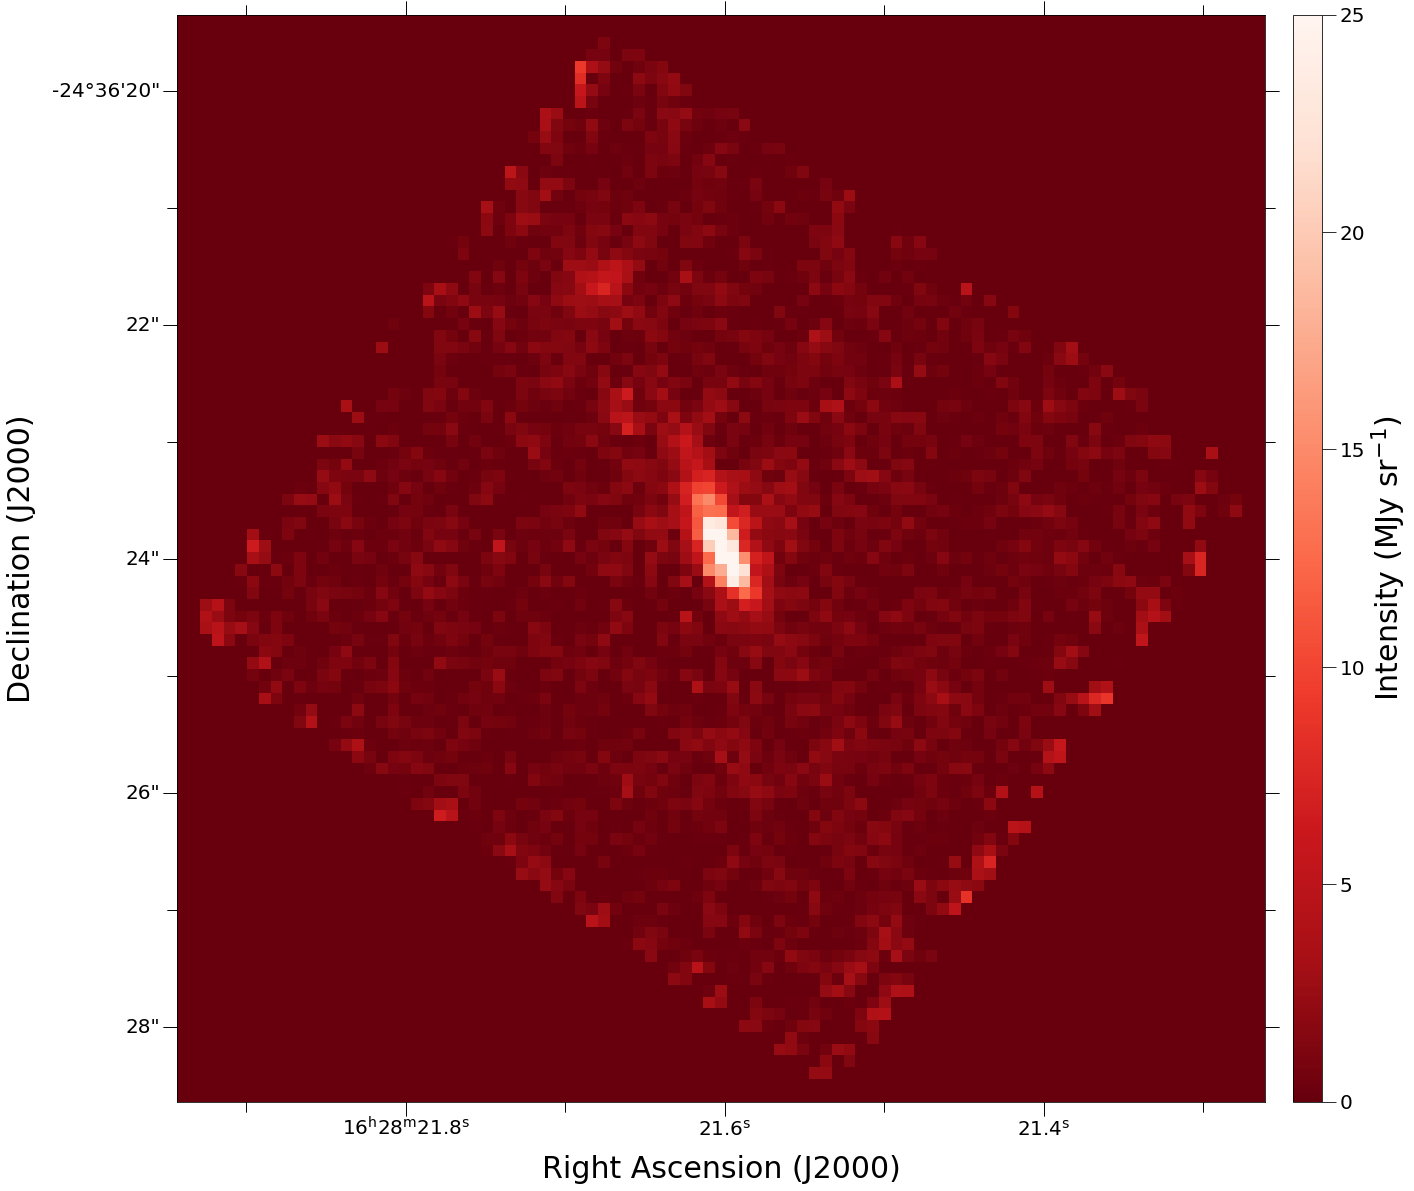

In [28]:
# tests without aplpy
# 4) Use summed lines for molecules (e.g. H2, CO) to make overlays (like two atomic lines and continuum as rgb, blend, or overlaps) 
#plotting resulting image
# from astropy.coordinates import SkyCoord
# from astropy import units as u
# from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.wcs import WCS
# from astropy.wcs.utils import skycoord_to_pixel
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter
                
#minor formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14
    
fig = plt.figure(figsize=(20,20))
wcs = WCS(header_example)
ax = plt.subplot(projection=wcs)

#plotting
interval = ZScaleInterval()
data_interval = interval.get_limits(data_example)
norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=ds9_min, vmax=ds9_max)
# norm = ImageNormalize(stretch=SinhStretch(), vmin=ds9_min, vmax=ds9_max)
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=-8e-18, vmax=8e-18)
# norm = ImageNormalize(stretch=LogStretch(), vmin=0.1e-18, vmax=100e-18)

#labeling the hops protostellar sources
import matplotlib.colors #to setup a new color map that is friendly to colorblindness, can also see https://www.color-blindness.com/coblis-color-blindness-simulator/
im = ax.imshow(data_example , vmin=0, vmax=25, origin='lower', cmap='Reds_r',)

#general formatting
# ax.set_xlim(200, 1000)
# ax.set_ylim(300, 1100)
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   
ax.coords[0].set_minor_frequency(2) #for minor ticks
ax.coords[1].set_minor_frequency(2)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', which='minor', length=10)
ax.tick_params(axis='y', which='minor', length=10)
# ax.invert_yaxis() #done if needing declination increasing going up
# ax.invert_xaxis()

#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 

#color bar label and tick labels
cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Intensity \ (MJy \ {sr}^{-1})$', size=30)

# plt.savefig('f160w_diffepoch_2_1.png', dpi=300, bbox_inches="tight")
# plt.savefig('f160w_diffepoch_2_1.pdf', dpi=300, bbox_inches="tight")